# Lecture 4 - Correlation functions 

Author: J. R. Johansson (robert@riken.jp), https://jrjohansson.github.io/

This lecture series was developed by J.R. Johannson. The original lecture notebooks are available [here](https://github.com/jrjohansson/qutip-lectures).

This is a slightly modified version of the lectures, to work with the current release of QuTiP. You can find these lectures as a part of the [qutip-tutorials repository](https://github.com/qutip/qutip-tutorials). This lecture and other tutorial notebooks are indexed at the [QuTiP Tutorial webpage](https://qutip.org/tutorials.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, coherent_dm, correlation_2op_2t, destroy, fock_dm,
                   mesolve, qeye, steadystate, tensor)

%matplotlib inline

## First-order coherence function


Consider an oscillator that is interacting with a thermal environment. If the oscillator initially is in a coherent state, it will gradually decay to a thermal (incoherent) state. The amount of coherence can be quantified using the first-order optical coherence function

<center>
    $\displaystyle g^{(1)}(\tau) = \frac{\langle a^\dagger(\tau)a(0)\rangle}{\sqrt{\langle a^\dagger(\tau)a(\tau)\rangle\langle a^\dagger(0)a(0)\rangle}}$
</center>

For a coherent state $|g^{(1)}(\tau)| = 1$, and for a completely incoherent (thermal) state $g^{(1)}(\tau) = 0$. 

The following code calculates and plots $g^{(1)}(\tau)$ as a function of $\tau$.

### Example: Decay of a coherent state to an incoherent (thermal) state

In [2]:
N = 20
taulist = np.linspace(0, 10.0, 200)
a = destroy(N)
H = 2 * np.pi * a.dag() * a

# collapse operator
G1 = 0.75
n_th = 2.00  # bath temperature in terms of excitation number
c_ops = [np.sqrt(G1 * (1 + n_th)) * a, np.sqrt(G1 * n_th) * a.dag()]

# start with a coherent state
rho0 = coherent_dm(N, 2.0)

# first calculate the occupation number as a function of time
n = mesolve(H, rho0, taulist, c_ops, [a.dag() * a]).expect[0]
n = np.array(n)

# calculate the correlation function G1 and normalize with n to obtain g1
G1 = correlation_2op_2t(H, rho0, None, taulist, c_ops, a.dag(), a)
# extract taulist results
if len(G1.shape) == 2:
    G1 = G1[0]

g1 = G1 / np.sqrt(n[0] * n)

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


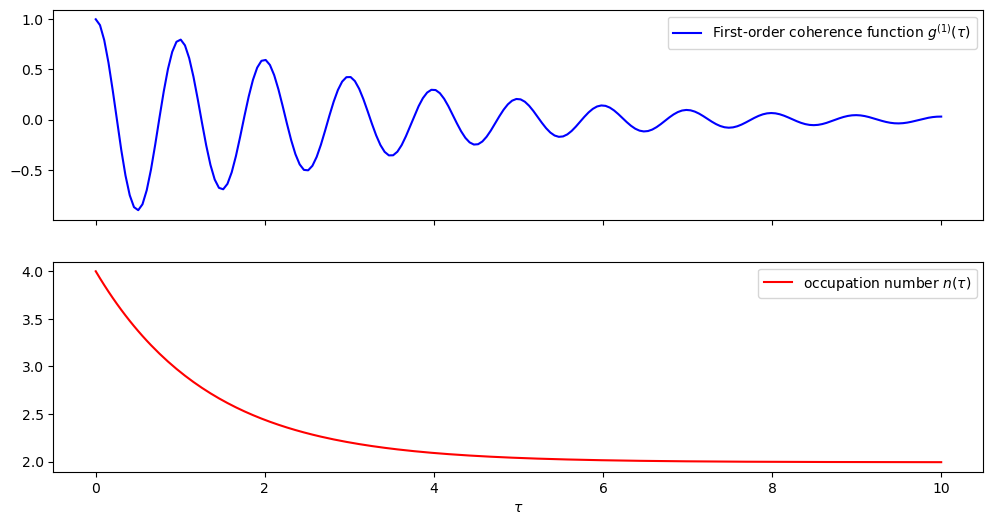

In [3]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

axes[0].plot(
    taulist, np.real(g1), "b",
    label=r"First-order coherence function $g^{(1)}(\tau)$"
)
axes[1].plot(taulist, np.real(n), "r", label=r"occupation number $n(\tau)$")
axes[0].legend()
axes[1].legend()
axes[1].set_xlabel(r"$\tau$");

## Second-order coherence function

<center>
    $\displaystyle g^{(2)}(\tau) = \frac{\langle a^\dagger(0)a^\dagger(\tau)a(\tau)a(0)\rangle}{\langle a^\dagger(0)a(0)\rangle^2}$
</center>

For a coherent state $|g^{(2)}(\tau)| = 1$, and for a thermal state $g^{(2)}(\tau) = 2$ (bunched photons, tend to appear together). 

The following code calculates and plots $g^{(2)}(\tau)$ as a function of $\tau$.

In [4]:
def correlation_ss_gtt(H, tlist, c_ops, a_op, b_op, c_op, d_op, rho0=None):
    """
    Calculate the correlation function <A(0)B(tau)C(tau)D(0)>

    (ss_gtt = steadystate general two-time)

    See, Gardiner, Quantum Noise, Section 5.2.1

    .. note::
        Experimental.
    """
    if rho0 is None:
        rho0 = steadystate(H, c_ops)

    return mesolve(H, d_op * rho0 * a_op, tlist, c_ops,
                   [b_op * c_op]).expect[0]

In [5]:
# calculate the correlation function G2 and normalize with n to obtain g2
G2 = correlation_ss_gtt(H, taulist, c_ops, a.dag(), a.dag(), a, a, rho0=rho0)
g2 = G2 / n**2

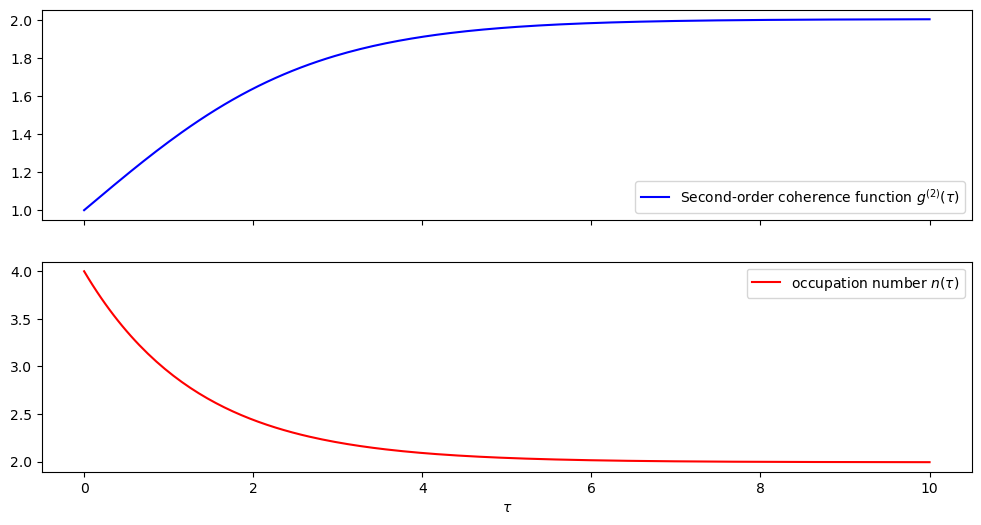

In [6]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

axes[0].plot(
    taulist, np.real(g2), "b",
    label=r"Second-order coherence function $g^{(2)}(\tau)$"
)
axes[1].plot(taulist, np.real(n), "r", label=r"occupation number $n(\tau)$")
axes[0].legend(loc=0)
axes[1].legend()
axes[1].set_xlabel(r"$\tau$");

## Leggett-Garg inequality

Definition: Given an observable $Q(t)$ that is bound below and above by $|Q(t)| \leq 1$, the assumptions of 

 * macroscopic realism
 * noninvasive measurements

implies that

<center>
$L(t_1, t_2) = \langle Q(t_1)Q(0)\rangle + \langle Q(t_1+t_2)Q(t_1)\rangle - \langle Q(t_1+t_2)Q(0)\rangle \leq 1$
</center>

If $Q$ is at a steady state at the initial time of measurement, we can set $\tau = t_1 = t_2$ and the Leggett-Garg inequality then reads

<center>
$L(\tau) = 2\langle Q(\tau)Q(0)\rangle - \langle Q(2\tau)Q(0)\rangle \leq 1$
</center>


### References

* [A. J. Leggett and A. Garg, Phys. Rev. Lett. 54, 857 (1985)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.54.857)
* [A. J. Leggett, J. Phys. Condens. Matter 14, R415 (2002)](http://dx.doi.org/10.1088/0953-8984/14/15/201)

In [7]:
def leggett_garg(c_mat):
    """
    For a given correlation matrix c_mat = <Q(t1+t2)Q(t1)>,
    calculate the Leggett-Garg correlation.
    """

    N, M = c_mat.shape

    lg_mat = np.zeros([N // 2, M // 2], dtype=complex)
    lg_vec = np.zeros(N // 2, dtype=complex)

    # c_mat(i, j) = <Q(dt i+dt j)Q(dt i)>
    # LG = <Q(t_1)Q(0)> + <Q(t_1+t_2)Q(t_1)> - <Q(t_1+t_2)Q(0)>

    for i in range(N // 2):
        lg_vec[i] = 2 * c_mat[0, i] - c_mat[0, 2 * i]

        for j in range(M // 2):
            lg_mat[i, j] = c_mat[0, i] + c_mat[i, j] - c_mat[0, i + j]

    return lg_mat, lg_vec

### Example: Leggett-Garg inequality for two coupled resonators (optomechanical system)


References:

 * [N. Lambert, J.R. Johansson, F. Nori, Phys. Rev. B 82, 245421 (2011)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.84.245421).

In [8]:
wc = 1.0 * 2 * np.pi  # cavity frequency
wa = 1.0 * 2 * np.pi  # resonator frequency
g = 0.3 * 2 * np.pi  # coupling strength
kappa = 0.075  # cavity dissipation rate
gamma = 0.005  # resonator dissipation rate
Na = Nc = 3  # number of cavity fock states
n_th = 0.0  # avg number of thermal bath excitation

tlist = np.linspace(0, 7.5, 251)
tlist_sub = tlist[0:int((len(tlist) / 2))]

In [9]:
# start with an excited resonator
rho0 = tensor(fock_dm(Na, 0), fock_dm(Nc, 1))

a = tensor(qeye(Nc), destroy(Na))
c = tensor(destroy(Nc), qeye(Na))

na = a.dag() * a
nc = c.dag() * c

H = wa * na + wc * nc - g * (a + a.dag()) * (c + c.dag())

In [10]:
# measurement operator on resonator
Q = na  # photon number resolving detector
# fock-state |1> detector
# Q = tensor(qeye(Nc), 2 * fock_dm(Na, 1) - qeye(Na))
# click or no-click detector
# Q = tensor(qeye(Nc), qeye(Na) - 2 * fock_dm(Na, 0))

In [11]:
c_op_list = []

rate = kappa * (1 + n_th)
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * c)

rate = kappa * n_th
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * c.dag())

rate = gamma * (1 + n_th)
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * a)

rate = gamma * n_th
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * a.dag())

### Calculate the correlation function $\langle Q(t_1+t_2)Q(t_1)\rangle$

Using the regression theorem, and QuTiP function `correlation`.

In [12]:
corr_mat = correlation_2op_2t(H, rho0, tlist, tlist, c_op_list, Q, Q)

### Calculate the Leggett-Garg correlation

In [13]:
LG_tt, LG_t = leggett_garg(corr_mat)

### Plot results

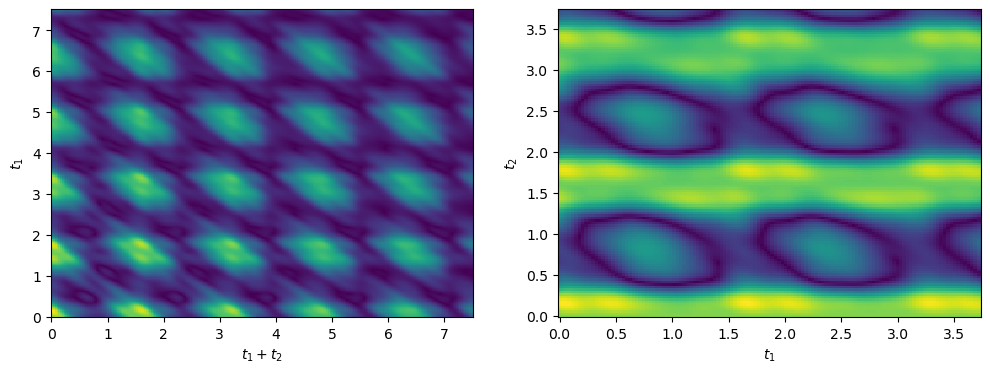

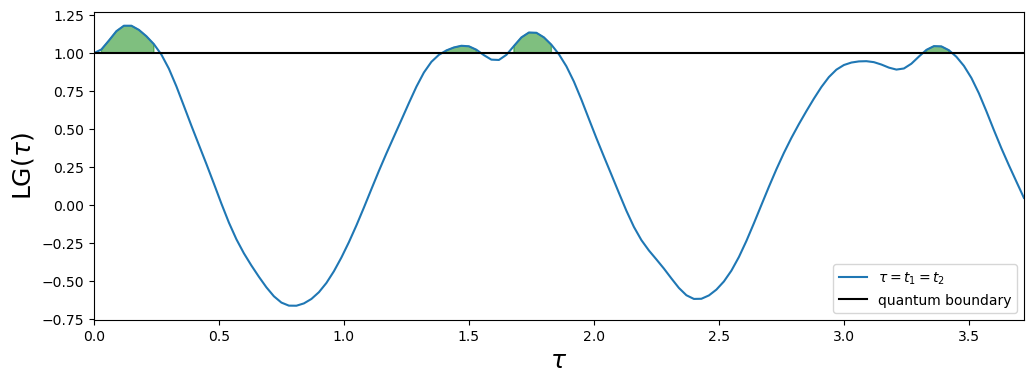

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].pcolor(tlist, tlist, abs(corr_mat), edgecolors="none")
axes[0].set_xlabel(r"$t_1 + t_2$")
axes[0].set_ylabel(r"$t_1$")
axes[0].autoscale(tight=True)

axes[1].pcolor(tlist_sub, tlist_sub, abs(LG_tt), edgecolors="none")
axes[1].set_xlabel(r"$t_1$")
axes[1].set_ylabel(r"$t_2$")
axes[1].autoscale(tight=True)

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.plot(tlist_sub, np.diag(np.real(LG_tt)), label=r"$\tau = t_1 = t_2$")
axes.plot(tlist_sub, np.ones(tlist_sub.shape), "k", label=r"quantum boundary")
axes.fill_between(
    tlist_sub,
    np.diag(np.real(LG_tt)),
    1,
    where=(np.diag(np.real(LG_tt)) > 1),
    color="green",
    alpha=0.5,
)
axes.set_xlim([0, max(tlist_sub)])
axes.legend(loc=0)
axes.set_xlabel(r"$\tau$", fontsize=18)
axes.set_ylabel(r"LG($\tau$)", fontsize=18);

### Software versions

In [15]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.0.dev0+4033695
Numpy Version:      2.2.4
Scipy Version:      1.15.2
Cython Version:     3.0.12
Matplotlib Version: 3.10.1
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------



qutip-jax: 0.1.1.dev5
qutip-qtrl: 0.2.0.dev0+acb71a0
qutip-qip: 0.5.0.dev0+d58a82d

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
